In [2]:
%cd /home/teresakim/fungiclef-2024/

/home/teresakim/fungiclef-2024


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pyspark.sql.functions as f
import pyspark.ml as ml
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, FloatType, IntegerType
import fungiclef.embedding.transforms as trans
from fungiclef.utils import get_spark

In [5]:
spark = get_spark(**{
    "spark.sql.parquet.enableVectorizedReader": False, 
})
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/28 22:07:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/28 22:07:52 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/04/28 22:07:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
gcs_parquet_path = "gs://dsgt-clef-fungiclef-2024/"

# define the embedding path here
#------------resnet embedding (original)
# input_folder = f"data/parquet/DF20_300px_resnet18" # 295,938 total
# embedding_name = "ResNet"

# ------------resnet embedding (300px full set)
# input_folder = f"data/parquet/DF20_300px_and_DF21_300px_corrected_FULL_SET_embedding/resnet"
# embedding_name = "ResNet_300px"

# ------------dino embedding (300px full set 8x8)
# input_folder = "data/parquet/DF20_300px_and_DF21_300px_corrected_FULL_SET_embedding/dino_dct/data" # 356,738
# embedding_name = "DINO 8x8"

# ------------dino embedding (300px full set 16x16)
# input_folder = "data/parquet/DF20_300px_and_DF21_300px_corrected_FULL_SET_embedding/dino_dct_16/data" # 356,738
# embedding_name = "DINO 16x16"

# ------------dino embedding (300px full set CLT)
input_folder = "production/dino_cls/" # 350,974
embedding_name = "DINO CLS"

# ------------clip embedding # TBD
# embedding_name = "CLIP"

embedding_df = spark.read.parquet(gcs_parquet_path+input_folder)
embedding_df.printSchema()
embedding_df.count()

root
 |-- image_path: string (nullable = true)
 |-- observationID: long (nullable = true)
 |-- month: double (nullable = true)
 |-- day: double (nullable = true)
 |-- locality: long (nullable = true)
 |-- level0Gid: long (nullable = true)
 |-- level1Gid: long (nullable = true)
 |-- level2Gid: long (nullable = true)
 |-- Substrate: long (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- CoorUncert: double (nullable = true)
 |-- Habitat: long (nullable = true)
 |-- MetaSubstrate: long (nullable = true)
 |-- kingdom: long (nullable = true)
 |-- phylum: long (nullable = true)
 |-- class: long (nullable = true)
 |-- order: long (nullable = true)
 |-- family: long (nullable = true)
 |-- genus: long (nullable = true)
 |-- species: long (nullable = true)
 |-- poisonous: long (nullable = true)
 |-- class_id: long (nullable = true)
 |-- dataset: string (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: double (contain

350974

### option 1

In [8]:
# option 1: sampling by top 5 species

# count the occurrences of each species and order by the count descending
species_counts = embedding_df.groupBy("species").count().orderBy(col("count").desc())

# get the top 5 species
top_species = species_counts.limit(5).select("species").rdd.flatMap(lambda x: x).collect()

In [9]:
# define a sample fraction, example: 10%
sample_fraction = 1.0

# filter the original df to include only records from the top 5 species and sample from them
sampled_df = embedding_df.filter(col("species").isin(top_species)).sampleBy("species", fractions={x: sample_fraction for x in top_species})

sampled_df.show()

24/04/28 22:09:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-------------+-----+----+--------+---------+---------+---------+---------+------------------+---------+----------+-------+-------------+-------+------+-----+-----+------+-----+-------+---------+--------+-------+--------------------+-----------------+
|          image_path|observationID|month| day|locality|level0Gid|level1Gid|level2Gid|Substrate|          Latitude|Longitude|CoorUncert|Habitat|MetaSubstrate|kingdom|phylum|class|order|family|genus|species|poisonous|class_id|dataset|           embedding|__index_level_0__|
+--------------------+-------------+-----+----+--------+---------+---------+---------+---------+------------------+---------+----------+-------+-------------+-------+------+-----+-----+------+-----+-------+---------+--------+-------+--------------------+-----------------+
|2465026805-200675...|   2465026805| 12.0| 8.0|    8816|        9|       31|      133|        6|         54.765611|12.037556|      15.0|      2|            8|      1|     2|    0|  

In [10]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

# Convert to Pandas DF
# pandas_df = sampled_df.select(["embeddings", "species"]).toPandas() # resnet
# pandas_df = sampled_df.select(["dct_embedding", "species"]).toPandas() # dino
pandas_df = sampled_df.select(["embedding", "species"]).toPandas() # dino cls

# Extract features and labels
# emb_df = np.stack(pandas_df["embeddings"].values) # resnet
# emb_df = np.stack(pandas_df["dct_embedding"].values) # dino
emb_df = np.stack(pandas_df["embedding"].values) # dino cls
scaled_emb = StandardScaler().fit_transform(emb_df)
labels = pandas_df["species"].tolist()

spark.stop()

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# apply t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_emb)

def plot_cluster(pandas_df, embeddings, algorithm_name):
    # Plot the data
    fig, ax = plt.subplots(figsize=(8.8, 4.8), dpi=200)
    fig.suptitle(
        f"{algorithm_name} projection of top 5 fungi species ({embedding_name})",
        fontsize=14,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    top_species_idx = pandas_df["species"].value_counts().nlargest(5).index
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["species"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["species"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            # cmap="tab10",
            label=species,
            s=4,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    fig.savefig(f"notebooks/evaluation/visuals/{embedding_name}_{algorithm_name}.png")
    plt.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9446 samples in 0.005s...
[t-SNE] Computed neighbors for 9446 samples in 1.860s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9446
[t-SNE] Computed conditional probabilities for sample 2000 / 9446
[t-SNE] Computed conditional probabilities for sample 3000 / 9446
[t-SNE] Computed conditional probabilities for sample 4000 / 9446
[t-SNE] Computed conditional probabilities for sample 5000 / 9446
[t-SNE] Computed conditional probabilities for sample 6000 / 9446
[t-SNE] Computed conditional probabilities for sample 7000 / 9446
[t-SNE] Computed conditional probabilities for sample 8000 / 9446
[t-SNE] Computed conditional probabilities for sample 9000 / 9446
[t-SNE] Computed conditional probabilities for sample 9446 / 9446
[t-SNE] Mean sigma: 6.048146
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.954674
[t-SNE] KL divergence after 1000 iterations: 2.354926


In [13]:
def plot_cluster(pandas_df, embeddings, algorithm_name):
    # Plot the data
    fig, ax = plt.subplots(figsize=(8.8, 4.8), dpi=200)
    fig.suptitle(
        f"{algorithm_name} projection of top 5 fungi species ({embedding_name})",
        fontsize=14,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    top_species_idx = pandas_df["species"].value_counts().nlargest(5).index
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["species"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["species"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            # cmap="tab10",
            label=species,
            s=4,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    fig.savefig(f"notebooks/evaluation/visuals/{embedding_name}_{algorithm_name}.png")
    plt.show()

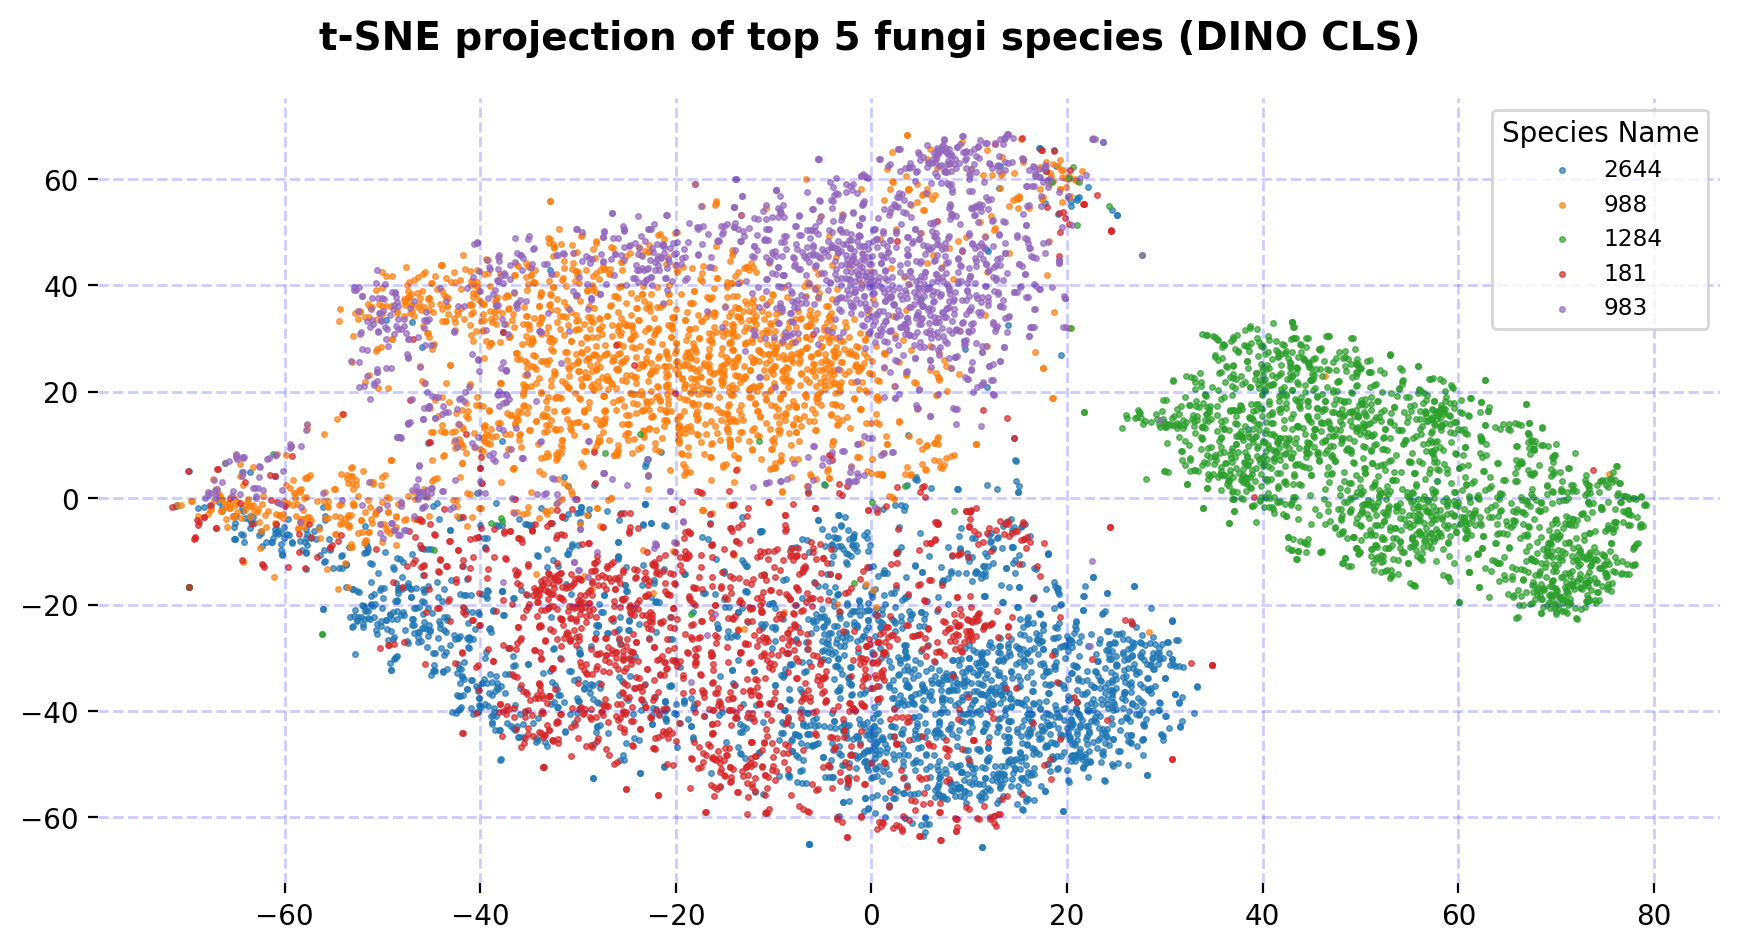

In [14]:
plot_cluster(pandas_df, tsne_results, algorithm_name="t-SNE")


In [ ]:
# resnet
# [t-SNE] Computing 91 nearest neighbors...
# [t-SNE] Indexed 9597 samples in 0.031s...
# [t-SNE] Computed neighbors for 9597 samples in 14.596s...
# [t-SNE] Computed conditional probabilities for sample 1000 / 9597
# [t-SNE] Computed conditional probabilities for sample 2000 / 9597
# [t-SNE] Computed conditional probabilities for sample 3000 / 9597
# [t-SNE] Computed conditional probabilities for sample 4000 / 9597
# [t-SNE] Computed conditional probabilities for sample 5000 / 9597
# [t-SNE] Computed conditional probabilities for sample 6000 / 9597
# [t-SNE] Computed conditional probabilities for sample 7000 / 9597
# [t-SNE] Computed conditional probabilities for sample 8000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9597 / 9597
# [t-SNE] Mean sigma: 8.020381
# [t-SNE] KL divergence after 250 iterations with early exaggeration: 93.062561
# [t-SNE] KL divergence after 1000 iterations: 3.017685

# dino 8x8
# [t-SNE] Computing 91 nearest neighbors...
# [t-SNE] Indexed 9597 samples in 0.001s...
# [t-SNE] Computed neighbors for 9597 samples in 2.311s...
# [t-SNE] Computed conditional probabilities for sample 1000 / 9597
# [t-SNE] Computed conditional probabilities for sample 2000 / 9597
# [t-SNE] Computed conditional probabilities for sample 3000 / 9597
# [t-SNE] Computed conditional probabilities for sample 4000 / 9597
# [t-SNE] Computed conditional probabilities for sample 5000 / 9597
# [t-SNE] Computed conditional probabilities for sample 6000 / 9597
# [t-SNE] Computed conditional probabilities for sample 7000 / 9597
# [t-SNE] Computed conditional probabilities for sample 8000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9597 / 9597
# [t-SNE] Mean sigma: 1.872417
# [t-SNE] KL divergence after 250 iterations with early exaggeration: 92.468254
# [t-SNE] KL divergence after 1000 iterations: 3.987825

# dino 16x16
# [t-SNE] Computing 91 nearest neighbors...
# [t-SNE] Indexed 9597 samples in 0.005s...
# [t-SNE] Computed neighbors for 9597 samples in 3.271s...
# [t-SNE] Computed conditional probabilities for sample 1000 / 9597
# [t-SNE] Computed conditional probabilities for sample 2000 / 9597
# [t-SNE] Computed conditional probabilities for sample 3000 / 9597
# [t-SNE] Computed conditional probabilities for sample 4000 / 9597
# [t-SNE] Computed conditional probabilities for sample 5000 / 9597
# [t-SNE] Computed conditional probabilities for sample 6000 / 9597
# [t-SNE] Computed conditional probabilities for sample 7000 / 9597
# [t-SNE] Computed conditional probabilities for sample 8000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9597 / 9597
# [t-SNE] Mean sigma: 3.329385
# [t-SNE] KL divergence after 250 iterations with early exaggeration: 111.616203
# [t-SNE] KL divergence after 1000 iterations: 4.446006

# dino CLS
# [t-SNE] Computing 91 nearest neighbors...
# [t-SNE] Indexed 9446 samples in 0.005s...
# [t-SNE] Computed neighbors for 9446 samples in 1.860s...
# [t-SNE] Computed conditional probabilities for sample 1000 / 9446
# [t-SNE] Computed conditional probabilities for sample 2000 / 9446
# [t-SNE] Computed conditional probabilities for sample 3000 / 9446
# [t-SNE] Computed conditional probabilities for sample 4000 / 9446
# [t-SNE] Computed conditional probabilities for sample 5000 / 9446
# [t-SNE] Computed conditional probabilities for sample 6000 / 9446
# [t-SNE] Computed conditional probabilities for sample 7000 / 9446
# [t-SNE] Computed conditional probabilities for sample 8000 / 9446
# [t-SNE] Computed conditional probabilities for sample 9000 / 9446
# [t-SNE] Computed conditional probabilities for sample 9446 / 9446
# [t-SNE] Mean sigma: 6.048146
# [t-SNE] KL divergence after 250 iterations with early exaggeration: 85.954674
# [t-SNE] KL divergence after 1000 iterations: 2.354926

### option 2